In [1]:
import cv2
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import scipy
import yaml

In [8]:
# Загрузка параметров из YAML файла
with open('./struct_params.yaml', 'r') as file:
    data = yaml.safe_load(file)

parser:

--frame --params parameters_frame --figures BigCircle SmallCircle --center --figures BigCircle

class Figure: определение фигуры, ее параметры (размеры, расположение, поля, скругления....)

class Frame: определение рамки, ее параметры (расположение рамки, количесвто рамок), фигуры в рамке, отрисовка рамки 

class Center: определение центра, фигуры центра

In [3]:
class Figure():
    def __init__(self, figure_class):
        self.name = figure_class['FigureClass']
        self.margin = figure_class['figure_params']['margin']
        self.gap = figure_class['figure_params']['gap'] 
        self.num = figure_class['figure_params']['num']
        self.h = figure_class['figure_params']['h']
        self.w = figure_class['figure_params']['w']
        self.radius = figure_class['figure_params']['radius']
        self.color = figure_class['figure_params']['color']
        self.def_angle = figure_class['figure_params']['default_angle']

        if 'Circle' in self.name:
            self.h = 2 * self.radius
            self.w = 2 * self.radius

        self.corner_radius = np.minimum(self.h, self.w)//2
        self.border_width = int((700 / np.tan(np.radians(self.def_angle))) // 12)
        print(self.border_width)
        self.border_color = 128     


    def draw_figure(self):
        if 'Circle' in self.name:
            img = np.zeros((2*self.radius + 2*self.margin, 2*self.radius + 2*self.margin), dtype=np.float32)
            img = cv2.circle(img, (img.shape[0]//2, img.shape[1]//2), self.radius, 255, -1)
            img = cv2.circle(img, (img.shape[0]//2, img.shape[1]//2), self.radius, 255, -1)

        else:
            # img = np.zeros_like((2*np.max(self.h, self.w) + 2*self.margin, 2*np.max(self.h, self.w) + 2*self.margin), dtype=np.float32)
            img = cv2.circle(img, (img.shape[0]//2, img.shape[1]//2), self.radius, 255, -1)
        return img
    
    def draw(self, img, position):
        if 'Circle' in self.name:
            # print(self.radius + self.border_width)
            # img = cv2.circle(img, position, self.radius + self.border_width, self.border_color, -1)
            img = cv2.circle(img, position, self.radius, self.color, -1)
            


        else:
            print(self.h)
            print(img.shape[0]//4, img.shape[1]//4)
            # print(position[0], position[1] + self.corner_radius)
            # img = plt.scatter(position[0], position[1] + self.corner_radius)
            for i in range(self.num):
                # img = cv2.rectangle(img, (position[0] + self.corner_radius + self.border_width, position[1]), (position[0] + np.maximum(self.w, self.h) + self.corner_radius + self.border_width, position[1] + np.minimum(self.w, self.h)), self.border_color, -1)
                # img = cv2.circle(img, (position[0] + self.corner_radius + self.border_width, position[1] + self.corner_radius + self.border_width), self.corner_radius + self.border_width, self.border_color, -1)
                # img = cv2.circle(img, (position[0] + np.maximum(self.w, self.h) + self.corner_radius, position[1] + np.minimum(self.w, self.h) - self.corner_radius), self.corner_radius + self.border_width, self.border_color, -1)

                img = cv2.rectangle(img, (position[0] + self.corner_radius, position[1]), (position[0] + np.maximum(self.w, self.h) + self.corner_radius, position[1] + np.minimum(self.w, self.h)), 255, -1)
                img = cv2.circle(img, (position[0] + self.corner_radius, position[1] + self.corner_radius), self.corner_radius, self.color, -1)
                img = cv2.circle(img, (position[0] + np.maximum(self.w, self.h) + self.corner_radius, position[1] + np.minimum(self.w, self.h) - self.corner_radius), self.corner_radius, self.color, -1)

                position = (position[0], position[1] + np.minimum(self.w, self.h) + self.gap + 2*self.border_width)
                print(position)

        return img

In [4]:
class Frame():
    def __init__(self, img, edge_figure, linear_figure, num_linear_x, num_linear_y):
        self.frame_y = img.shape[0]
        self.frame_x = img.shape[1]

        self.num_linear_x = num_linear_x
        self.num_linear_y = num_linear_y
        
        self.num_edges = 4
        self.edge_figure = edge_figure
        self.linear_figure = linear_figure

        self.top_left = (edge_figure.margin + edge_figure.h // 2, edge_figure.margin + edge_figure.w // 2)
        self.bottom_right = (self.frame_x - edge_figure.margin - edge_figure.h // 2, \
                             self.frame_y - edge_figure.margin - edge_figure.w // 2)

        self.top_right = (self.frame_x - edge_figure.margin - edge_figure.h // 2, \
                          edge_figure.margin + edge_figure.w // 2)
        self.bottom_left = (edge_figure.margin + edge_figure.h // 2, \
                            self.frame_y - edge_figure.margin - edge_figure.w // 2)


        self.hor_size = (self.frame_x - edge_figure.w - edge_figure.margin) - \
            (0+edge_figure.w + edge_figure.margin)
        self.vert_size = (self.frame_y - edge_figure.h - edge_figure.margin) - \
            (0+edge_figure.h + edge_figure.margin)
        self.start_point = (edge_figure.h + edge_figure.margin, \
                            edge_figure.w + edge_figure.margin)

        self.positions = [self.top_left, self.bottom_right, self.top_right, self.bottom_left] # hor, vert

        self.gap_hor = (((((self.frame_x - edge_figure.w - edge_figure.margin) - \
                           (0+edge_figure.w + edge_figure.margin)))//self.num_linear_x) - linear_figure.w)

        self.gap_vert = (((((self.frame_y - edge_figure.h - edge_figure.margin) - \
                            (0+edge_figure.h + edge_figure.margin)))//self.num_linear_y) - linear_figure.h)
        

        self.gap_from_edge_figure_hor = self.edge_figure.h//2 + self.gap_hor
        self.gap_from_edge_figure_vert = self.edge_figure.w//2 + self.gap_vert

        
        self.linear_positions = [(self.top_left[0] + self.gap_from_edge_figure_hor, self.top_left[0]),\
                                 (self.bottom_left[0] + self.gap_from_edge_figure_hor, self.bottom_left[1]),\
                                 (self.top_left[0], self.top_left[0] + self.gap_from_edge_figure_vert),\
                                    (self.top_right[0], self.top_right[1] + self.gap_from_edge_figure_vert)
                                    ]
    
    def draw_frame(self, img):
        for position in self.positions:
            img = self.edge_figure.draw(img, position)

        for position in self.linear_positions[0:2]:
            start_hor = position[0]
            start_vert = position[1]  
            for i in range(0, self.num_linear_x):
                hor = start_hor + i * (self.linear_figure.w + self.gap_hor + (self.linear_figure.w//2))
                vert = start_vert
                img = self.linear_figure.draw(img, (hor, vert))

        for position in self.linear_positions[2:]:
            start_hor = position[0]
            start_vert = position[1]  
            for i in range(0, self.num_linear_y):
                hor = start_hor 
                vert = start_vert + i * (self.linear_figure.h + self.gap_vert + (self.linear_figure.h//2))
                img = self.linear_figure.draw(img, (hor, vert))

    
    def get_frame_size(self):
        frame_size = (self.vert_size, self.hor_size)
        start_point = self.start_point
        return frame_size, start_point


In [5]:
class Center():
    def __init__(self, start_point, size, figures, nums):
        self.start_point = start_point
        self.size = size
        self.figures = figures
        self.nums_figures = nums

        self.nums_at_all  = np.sum(nums)

        if self.nums_at_all % 3 == 0 and self.nums_at_all % 2:
            self.size_s_hor = self.size[1] // 3
            self.size_s_vert = self.size[0] // 2
            self.num_hor = 3
            self.num_vert = 2

        elif self.nums_at_all == 2:
            self.size_s_hor = self.size[1] // 2
            self.size_s_vert = self.size[0]
            self.num_hor = 2
            self.num_vert = 1
            
        elif self.nums_at_all % 2 == 0 and self.nums_at_all % 3 != 0:
            self.size_s_hor = self.size[1] // 2
            self.size_s_vert = self.size[0] // 2
            self.num_hor = 2
            self.num_vert = 2

        elif self.nums_at_all % 4 == 0 and self.nums_at_all % 3 == 0:
            self.size_s_hor = self.size[1] // 4
            self.size_s_vert = self.size[0] // 3
            self.num_hor = 4
            self.num_vert = 3

        elif self.nums_at_all % 4 == 0 and self.nums_at_all % 5 == 0:
            self.size_s_hor = self.size[1] // 5
            self.size_s_vert = self.size[0] // 4
            self.num_hor = 5
            self.num_vert = 4

        elif self.nums_at_all % 4 == 0 and self.nums_at_all // 4 > 1:
            self.size_s_vert = self.size[0] // 4
            self.size_s_hor = self.size[1] // self.size_s_vert
            self.num_hor = self.size_s_vert
            self.num_vert = 4

        elif self.nums_at_all == 1:
            self.size_s_hor = self.size[1]
            self.size_s_vert = self.size[0]
            self.num_hor = 1
            self.num_vert = 1

    def draw_center_figure(self, img):
        start_hor = self.start_point[1]
        start_vert = self.start_point[0]
        for hor_figures in range(self.num_hor):
            for i in self.nums_figures:
                for figure in self.figures:
                    center_hor = (start_hor + start_hor + self.size_s_hor) // 2
                    center_vert = (start_vert + start_vert + self.size_s_vert) // 2
                    figure.draw(img, (center_hor, center_vert))
                    start_hor = start_hor + self.size_s_hor
                self.nums_figures[self.nums_figures.index(i)] -= 1 

        start_hor = self.start_point[1]
        start_vert = self.start_point[0] + self.size_s_vert
        for hor_figures in range(self.num_hor):
            for i in self.nums_figures:
                if i != 0:
                    for figure in self.figures:
                        center_hor = (start_hor + start_hor + self.size_s_hor) // 2
                        center_vert = (start_vert + start_vert + self.size_s_vert) // 2
                        figure.draw(img, (center_hor, center_vert))
                        start_hor = start_hor + self.size_s_hor
                    self.nums_figures[self.nums_figures.index(i)] -= 1

        

10
2
2


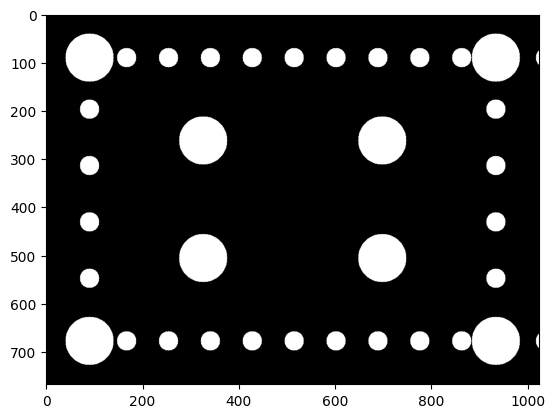

True

In [6]:
img = np.zeros((768, 1024), dtype=np.float32)
small_circle = Figure(data['figures'][0])
big_circle = Figure(data['figures'][1])


frame1 = Frame(img, big_circle, small_circle, 11, 5)
frame1.draw_frame(img)
frame1_size, start_center = frame1.get_frame_size()
center1 = Center(start_center, frame1_size, [Figure(data['figures'][1])], [4])
center1.draw_center_figure(img)
plt.imshow(img, cmap='gray')
plt.show()

cv2.imwrite('./input_mask.png', img)

2
720
192 256
(150, 234)
(150, 318)
(150, 402)
(150, 486)
(150, 570)
(150, 654)


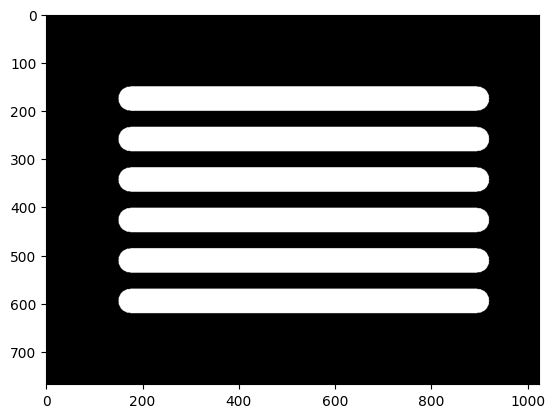

In [7]:
img = np.zeros((768, 1024), dtype=np.float32)
line = Figure(data['figures'][2])
img = line.draw(img, (150, 150))

plt.imshow(img, cmap='gray')
# plt.scatter(192, 256)

In [226]:
img.shape[0]

768

In [74]:
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='scunet_color_real_psnr', help='scunet_color_real_psnr, scunet_color_real_gan')
parser.add_argument('--test_dataset_name', type=str, default='real3', help='test set, bsd68 | set12 | G-123 | G46 | b2u_g123_stride200')
parser.add_argument('--show_img', type=bool, default=False, help='show the image')
parser.add_argument('--model_zoo', type=str, default='./model_zoo', help='path of model_zoo')
parser.add_argument('--test_dir', type=str, default='./data/test', help='path of testing folder')
parser.add_argument('--results', type=str, default='./results', help='path of results')



NameError: name 'argparse' is not defined

In [185]:
import argparse

In [192]:
parser = argparse.ArgumentParser()
parser.add_argument('--resolution', nargs='+', help='Разрешение маски: LowResolution для 768x1024 или HighResolution для 4096x6144')
parser.add_argument('--frame', nargs='+', help='Фигуры, из которых состоит рамка. Сначала угловые, затем массивы.')
parser.add_argument('--center', nargs='+', help='Изображения в центре рамки  и их количество')
parser.add_argument('--figures', nargs='+', help='Фигуры, расположенные в свободном пространстве')


_StoreAction(option_strings=['--figures'], dest='figures', nargs='+', const=None, default=None, type=None, choices=None, required=False, help='Фигуры, расположенные в свободном пространстве', metavar=None)

In [203]:
opt = parser.parse_args([
                        '--resolution', 'LowResolution',
                        '--frame', 'BigCircle', 'SmallCircle',
                        '--center', 'BigCircle', '4'
                        ])

In [204]:
data['image_size_conf']

[{'image': 'LowResolution', 'image_size_params': {'h': 768, 'w': 1024}},
 {'image': 'HighResolution', 'image_size_params': {'h': 4096, 'w': 6144}}]

In [222]:
if opt.resolution is not None:
    for resol in data['image_size_conf']:
        if resol['image'] == opt.resolution:
            img = np.zeros((resol['image']['image_size_params'].h, resol['image']['image_size_params'].w), dtype=np.float32)


frame_els = []
if opt.frame is not None:
    for class_name in opt.frame:
        for figure in data['figures']:
            if figure['FigureClass'] == class_name:
                frame_els.append(Figure(figure))


center_figures = []
num_figures = []
if opt.center is not None:
    i = 0
    while i < len(opt.center):
        for figure in data['figures']:
            if figure['FigureClass'] == opt.center[i]:
                center_figures.append(Figure(figure))
                num_figures.append(int(opt.center[i+1]))
        i = i + 2

In [223]:
num_figures

[4]

In [211]:
len(opt.center)

2

In [206]:
opt.frame

['BigCircle', 'SmallCircle']

In [199]:
for figure in data['image_size_conf']:
    if figure['image'] in opt.resolution:
        print('blyat')

blyat


In [97]:
frame1_size, start_center

((488, 744), (140, 140))

In [73]:
img.shape

(1024, 6144)

In [24]:
parser = ["SmallCircle", "BigCircle"]

20


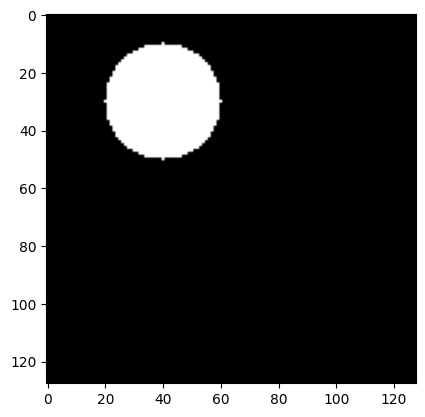

In [69]:
# # Меняем параметры на лету (пример изменения радиуса маленьких кружков)
# for figure in data['figures']:
#     if figure['class'] == "SmallCircle":
#         figure['parameters']['radius'] = 15  # Новый радиус

# Отрисовка фигур с измененными параметрами
# draw_frame(data['figures']["BigCircle"], data['figures']["SmallCircle"])
draw_frame(data['figures'][0], data['figures'][1])


# for figure in data['figures']:
#     if figure['FigureClass'] in parser:
        
#         if figure['FigureClass'] == "SmallCircle" or figure['figure_params'] == "BigCircle":
            
#             # print(figure['FigureClass'])
#             classs = figure
#             print(classs['figure_params']['radius'])
#             draw_circle(figure['figure_params']['radius'], (figure['figure_params']['position_x'], figure['figure_params']['position_y']), figure['figure_params']['color'])
        # elif figure['class'] == "большие квадраты":
        #     draw_square(figure['parameters']['side_length'], figure['parameters']['corner_radius'])


In [68]:
figure['figure_params']['radius']

50

In [ ]:
class = figure['FigureClass']

In [ ]:
\\wsl.localhost\Ubuntu\home\sasha\WSLProjects\metrics\input_data

In [28]:
dir = '/home/sasha/WSLProjects/metrics/input_data'

'/home/sasha/WSLProjects/metrics/input_data'